# Walmart sales data to forcast sales
**Goal:** The objective of this project is to predict Walmart store sales. We will train various time series
models, regression models, and deep learning models to forcast sales for individual store at different locations. . 

**Data Problem:** The task involves training and tuning multiple models that handle non-numeric values within the dataset. 

**Expected Results:** The expected outcome of this project is a highly accurate model capable of Forcasting weekly Sales of a store for a future date of choice. This helps store to optimize supply chain for demand and avoid overstocking or understocking.

In Future, We will gain further insights by conducting a global analysis using the statsmodels library for ARIMA to make more refined predictions. Additionally, we will perform a local analysis to evaluate the model's prediction process for specific store forcast. Lastly, we will extract insights from these analyses and recommend areas for future research, including studying seasonality and its impact on store sales.  

**Data**

The data is sourced from Kaggle.

https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast

This dataset contains store sales, data features that was collected from the Walmart dataset and encompasses 45 stores, complete with store details and monthly sales data, available on a weekly basis. Walmart aims to assess the impact of holidays on store sales, which is why the dataset includes four holiday weeks: Christmas, Thanksgiving, Super Bowl, and Labor Day. 

We have produced clean and relevent dataset after combining stores and features data. Since we shall be using clean dataset, 
hence we intend to analyze this dataset.

## Import and Reading the Data

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [178]:
# Load the sales features dataset
features_df = pd.read_csv('features.csv')
#store data
store_df= pd.read_csv('stores.csv')

In [179]:
sales_df = pd.read_csv('Walmart_Sales_Project.csv')


In [180]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store            6435 non-null   int64  
 1   Day              6435 non-null   int64  
 2   Month            6435 non-null   int64  
 3   Year             6435 non-null   int64  
 4   Weekly_Sales     6435 non-null   object 
 5   Holiday_Flag     6435 non-null   int64  
 6   Temperature      6435 non-null   float64
 7   Fuel_Price       6435 non-null   float64
 8   CPI              6435 non-null   float64
 9   Unemployment     6435 non-null   float64
 10  Month.1          6435 non-null   object 
 11  Day of the Week  6435 non-null   object 
dtypes: float64(4), int64(5), object(3)
memory usage: 603.4+ KB


In [181]:
# Rename column 'Month.1' to 'Date'
sales_df = sales_df.rename(columns={'Month.1': 'Date'})
print(sales_df.shape)
sales_df.head()

(6435, 12)


,Store,Day,Month,Year,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Date,Day of the Week
0,1,13,1,2012,"$ 1,459,601.17",0,48.53,3.261,219.89,7.348,1/13/2012,Fri
1,2,13,1,2012,"$ 1,744,725.48",0,45.99,3.261,219.53,7.057,1/13/2012,Fri
2,3,13,1,2012,"$ 367,438.62",0,51.86,3.261,223.38,6.833,1/13/2012,Fri
3,4,13,1,2012,"$ 1,941,676.61",0,34.41,3.263,130.24,4.607,1/13/2012,Fri
4,5,13,1,2012,"$ 291,454.52",0,48.86,3.261,220.48,5.943,1/13/2012,Fri


#### Data Overview 

- 6435 samples/rows 
- columns: 
    1. 12 parameters 
    2. Important columns: Day of the Week, Temperature,	Fuel_Price,	CPI,	CPI,	Day of the Week
    3. Target column Weekly_Sales
    4. Clean data so null values

#### Data Setup

In [184]:
#using a random sample of 5,000 entries for model training
df_setup = sales_df.sample(5000, random_state = 42)
#df_setup.columns = df_setup.columns.str.replace(' ', '')

In [185]:
# Convert 'Day of the Week' to day no in week objects
#data['Day of the Week'] = pd.to_datetime(data['Day of the Week']).data.dayofweek
day_mapping = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
df_setup['Day of the Week'] = df_setup['Day of the Week'].map(day_mapping)

In [186]:
df_setup['Sales_Year'] = pd.to_datetime(df_setup['Date'], format='%m/%d/%Y').dt.year
#df_setup['Sales_Month'] = pd.to_datetime(df_setup['Date'], format='%m/%d/%Y').dt.month
#df_setup['Sales_Day'] = pd.to_datetime(df_setup['Date'], format='%m/%d/%Y').dt.day


In [187]:
df = df_setup.copy()
df = df.drop(columns=['Date'])

## Exploratory Data Analysis
### Vikash Sinha

In [189]:
df.head(10)

,Store,Day,Month,Year,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day of the Week,Sales_Year
2436,7,24,9,2010,"$ 488,008.83",0,47.55,2.793,190.57,9.017,4,2010
3361,32,28,10,2011,"$ 1,185,391.96",0,42.76,3.550,195.33,8.513,4,2011
233,9,14,1,2011,"$ 458,086.69",0,36.43,2.983,214.97,6.416,4,2011
3667,23,30,7,2010,"$ 1,319,773.55",0,69.71,2.792,132.60,5.326,4,2010
5011,17,4,2,2011,"$ 816,603.05",0,11.29,2.974,127.72,6.866,4,2011
4850,36,1,7,2011,"$ 354,270.77",0,85.33,3.502,213.93,8.177,4,2011
3891,22,1,10,2010,"$ 905,987.17",0,69.31,2.717,136.63,8.572,4,2010
1699,35,20,8,2010,"$ 1,033,719.50",0,75.16,2.779,136.52,8.861,4,2010
2742,43,25,11,2011,"$ 669,965.22",1,55.70,3.236,210.09,10.148,4,2011
1703,39,20,8,2010,"$ 1,471,816.52",0,85.73,2.664,210.36,8.360,4,2010


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2436 to 4232
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store            5000 non-null   int64  
 1   Day              5000 non-null   int64  
 2   Month            5000 non-null   int64  
 3   Year             5000 non-null   int64  
 4   Weekly_Sales     5000 non-null   object 
 5   Holiday_Flag     5000 non-null   int64  
 6   Temperature      5000 non-null   float64
 7   Fuel_Price       5000 non-null   float64
 8   CPI              5000 non-null   float64
 9   Unemployment     5000 non-null   float64
 10  Day of the Week  5000 non-null   int64  
 11  Sales_Year       5000 non-null   int32  
dtypes: float64(4), int32(1), int64(6), object(1)
memory usage: 488.3+ KB


In [191]:
df.isna().sum()

Store              0
Day                0
Month              0
Year               0
Weekly_Sales       0
Holiday_Flag       0
Temperature        0
Fuel_Price         0
CPI                0
Unemployment       0
Day of the Week    0
Sales_Year         0
dtype: int64

***Data is clean and ready to pre-processed for visualizing and training***

#### Data Preprocessing:


In [194]:
# Trim whitespace from the column name 'Weekly_Sales'
#df = df.rename(columns={'Weekly_Sales': 'WeeklySales'})
df['Weekly_Sales'] = df['Weekly_Sales'].replace('[\$,]', '', regex=True).astype(float)

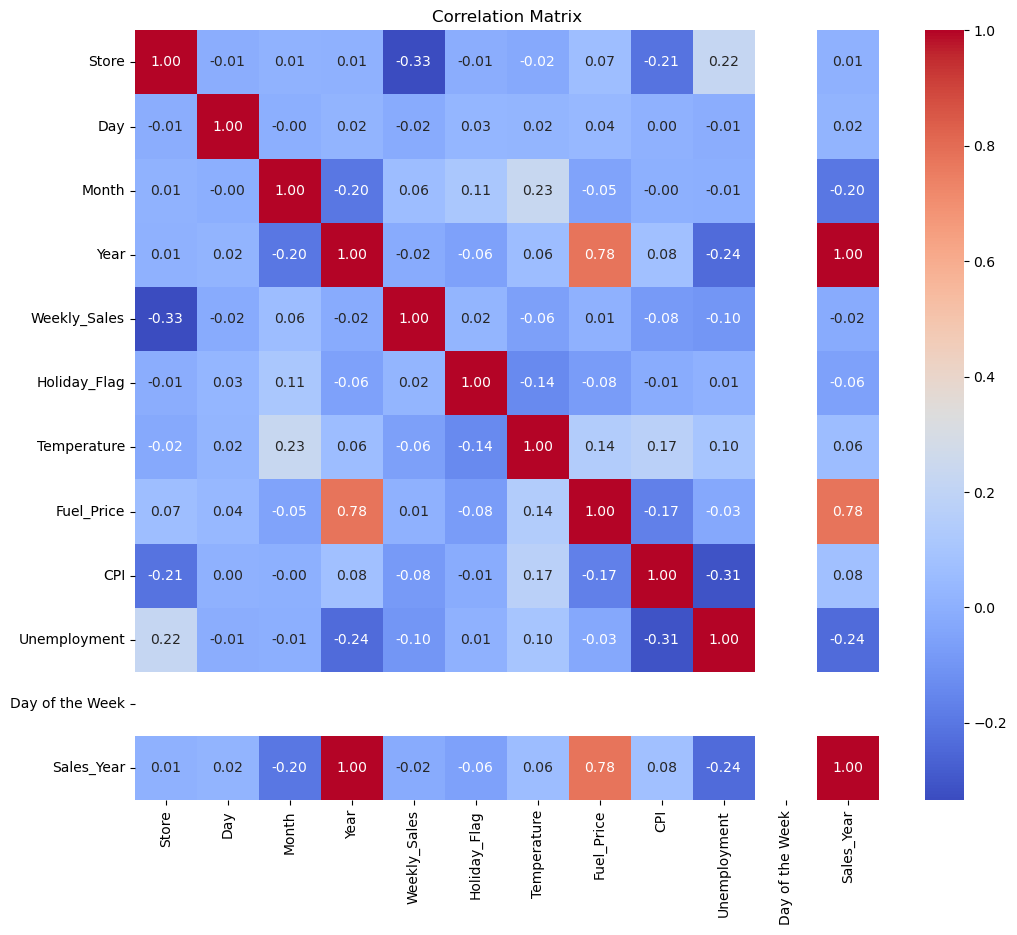

In [195]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**Features highly correlated with Weekly Sales(Target Feature)**

In [197]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Select only the correlation of 'Fare' with other columns
fare_correlation = correlation_matrix['Weekly_Sales']

# Sort the correlations in descending order
fare_correlation_sorted = fare_correlation.sort_values(ascending=False)

# Filter out columns with correlation above a certain threshold (e.g., 0.1)
threshold = 0.05
highly_correlated_features = fare_correlation_sorted[abs(fare_correlation_sorted) > threshold]

print("Features highly correlated with Sales:\n", highly_correlated_features)

Features highly correlated with Sales:
 Weekly_Sales    1.000000
Month           0.060096
Temperature    -0.061388
CPI            -0.079930
Unemployment   -0.098453
Store          -0.334061
Name: Weekly_Sales, dtype: float64


**Further visualization of highly correlated Features(Unemployment, CPI, Month, Temperature )  with Weekly Sales(Target Feature)**

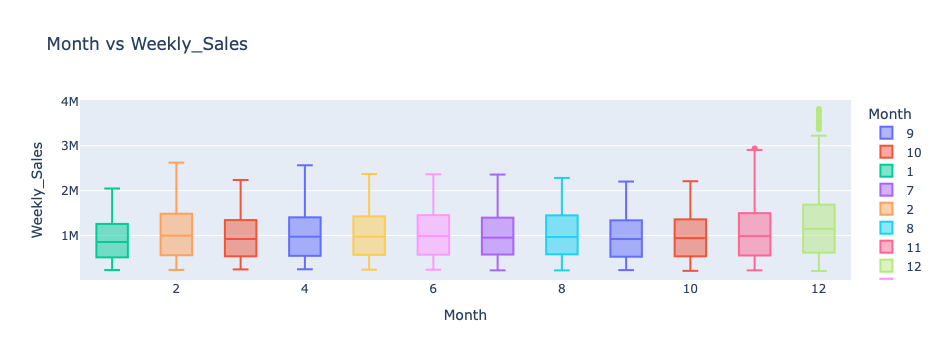

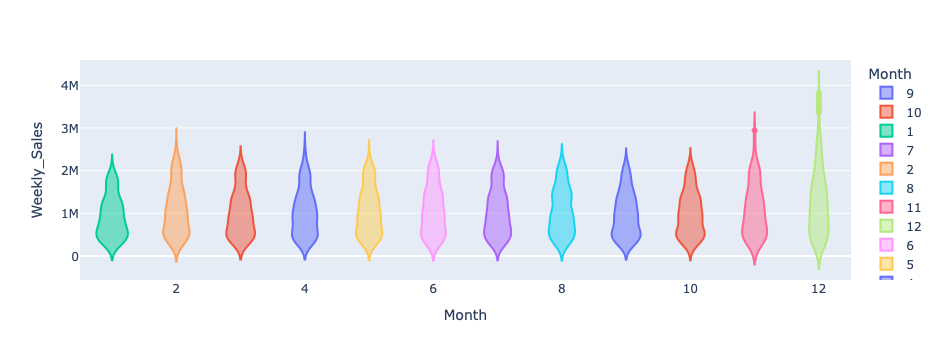

In [199]:
import plotly.express as px
fig = px.box(df, x='Month', y='Weekly_Sales', color='Month', title="Month vs Weekly_Sales")
fig.show()
fig = px.violin(df, x='Month', y='Weekly_Sales', color='Month')
fig.show()

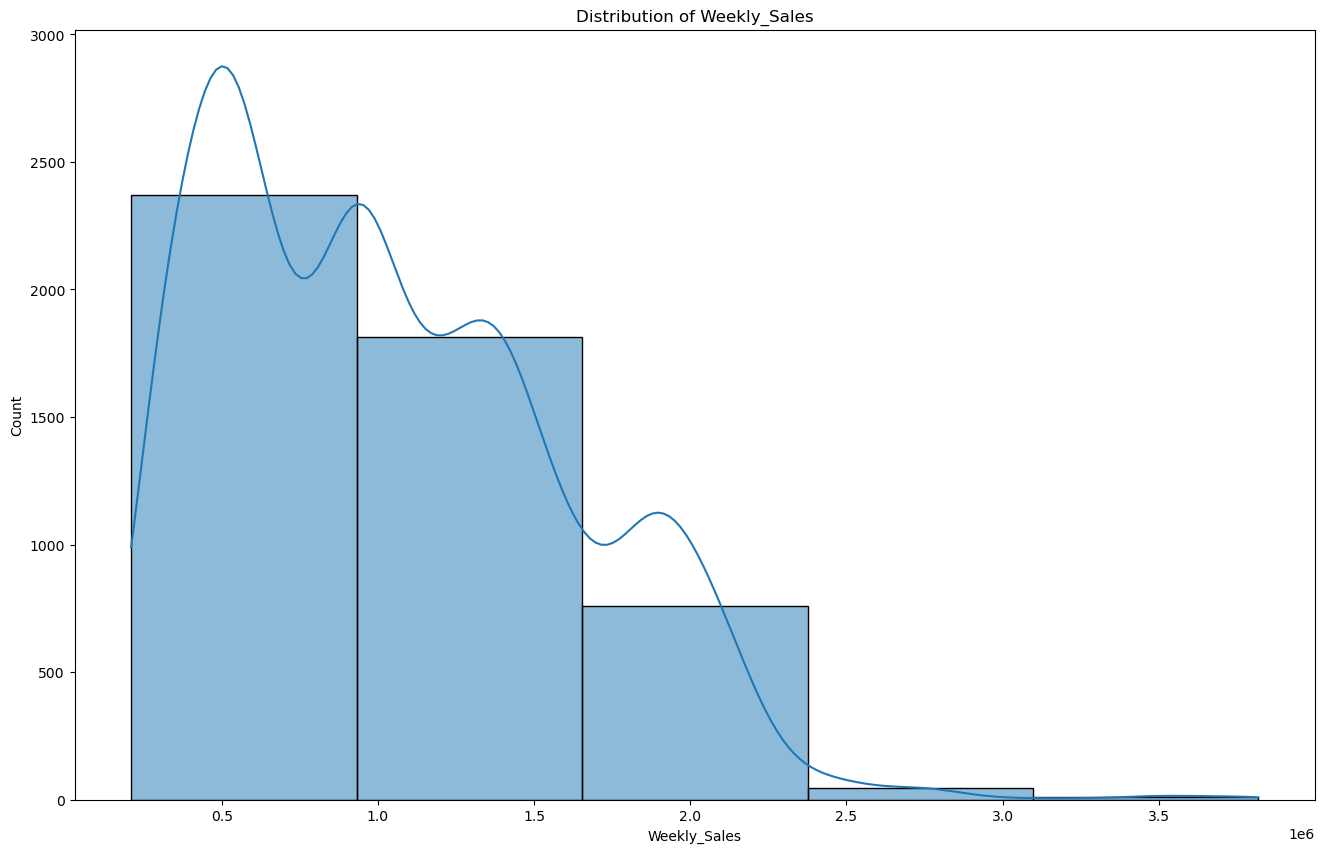

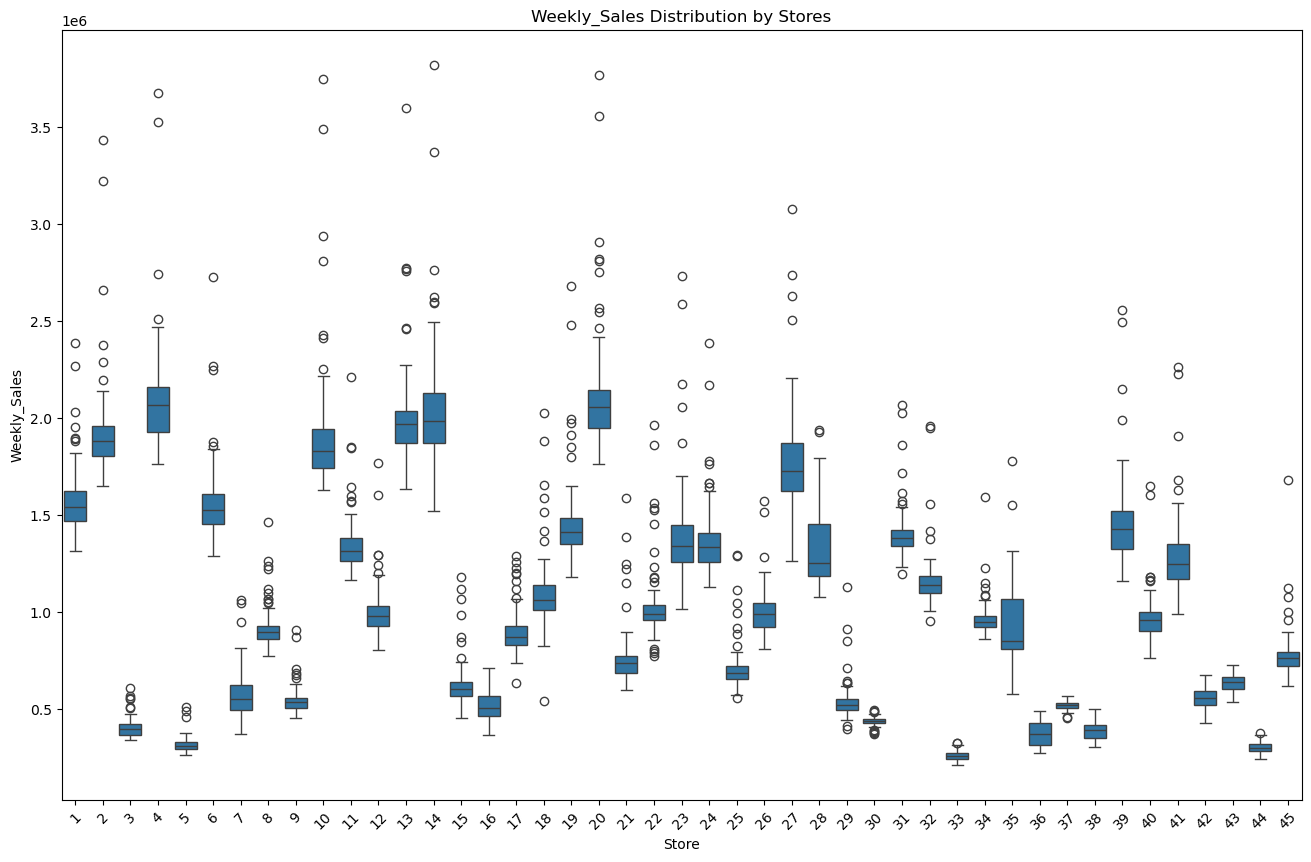

In [200]:
# Plot distribution of Weekly Sales
plt.figure(figsize=(16,10))
sns.histplot(df['Weekly_Sales'], kde=True, bins=5)
plt.title('Distribution of Weekly_Sales')
plt.show()

# Boxplot of Weekly Sales per store
plt.figure(figsize=(16,10))
sns.boxplot(x='Store', y='Weekly_Sales', data=df)
plt.title('Weekly_Sales Distribution by Stores')
plt.xticks(rotation=45)
plt.show()

## Feature Selection
### Vikash Sinha

In [202]:
# Models


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
#from sklearn.ensemble import GradientBoostingRegressor as GBR
#from xgboost import XGBRegressor
#from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [203]:


data = df.copy()
#X = data.drop(['Day' ,'Year', 'Sales_Year','Holiday_Flag','Fuel_Price','Day of the Week', 'Weekly_Sales'], axis=1)
X = data.drop(['Day' ,'Year', 'Sales_Year','Weekly_Sales'], axis=1)

y = data['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

**Features selection** 


In [205]:
# Initialize Scaler
scaler = StandardScaler()

# Apply
X_scaled = scaler.fit_transform(X)

# Create a new instance of the random forest regressor
rfr = RandomForestRegressor()

# Train the model on the scaled feature matrix (X_scaled) and the target variable (Y)
rfr.fit(X_scaled, y)

# Collect the feature importances for each input feature
feature_importances = rfr.feature_importances_

# Print the feature importances
print("Feature importances:")
for feature, importance in zip(X.columns, feature_importances):
    print("{:20}: {:.3f}".format(feature, importance))

Feature importances:
Store               : 0.677
Month               : 0.031
Holiday_Flag        : 0.007
Temperature         : 0.018
Fuel_Price          : 0.014
CPI                 : 0.162
Unemployment        : 0.091
Day of the Week     : 0.000


**Using Linear and Decision Tree Regression to evaluate Feature seletion**

In [207]:
# Collect the top 3 most important features
X_top_3 = X[['Store', 'CPI', 'Unemployment']]

# Collect the top 5 most important features
X_top_5 = X[['Store', 'CPI', 'Unemployment', 'Month', 'Temperature']]

# Scale the Top 3 Features Data
scaler = StandardScaler()
X_top_3 = scaler.fit_transform(X_top_3)

# Scale the Top 5 Features Data
scaler = StandardScaler()

In [208]:
# Set 1 : Full Data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42)

# Set 2 : Top 5 Features
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_top_5, y, test_size=0.3, shuffle=True, random_state=42)

# Set 3 : Top 3 features
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_top_3, y, test_size=0.3, shuffle=True, random_state=42)

# Set 4 : Most Important Feature
X_train, X_test, y_train, y_test = train_test_split(X['Month'].to_numpy().reshape(-1,1), y, test_size=0.3, shuffle=True, random_state=42)

In [209]:
##Performance calculator function
def perf_cal(y_true, y_pred):
    """Compute performance metrics for regression models."""
  
    results = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R-sq': r2_score(y_true, y_pred)
    }

    # Convert to DataFrame
    results_df = pd.DataFrame([results], index=['Performance Metrics'])
    return results_df
    
# Define Datasize keys for reference
DATA_SIZE = ['Full', 'Top-5', 'Top-1']


**Linear Regression** 

In [211]:
# Train and evaluate Linear Regression model: full set
lr_full = LinearRegression()
lr_full.fit(X_train_full, y_train_full)
lr_full_pred = lr_full.predict(X_test_full)
lr_full_scores = perf_cal(y_test_full, lr_full_pred)

# Print performance scores
print("Linear Regression Performance Scores:")
print(lr_full_scores)

Linear Regression Performance Scores:
                              RMSE           MSE            MAE      R-sq
Performance Metrics  510118.691458  2.602211e+11  417285.270097  0.148588


In [212]:
# Train and evaluate Linear Regression model: Top 5
lr_5 = LinearRegression()

# Train the Model
lr_5.fit(X_train_5, y_train_5)

# Make Predictions
lr_5_pred = lr_5.predict(X_test_5)

# Evaluate Performance
lr_5_scores = perf_cal(y_test_5, lr_5_pred)

# Display Performance Metrics
print("Linear Regression Performance Metrics (Subset 5)")
print(lr_5_scores)

Linear Regression Performance Metrics (Subset 5)
                              RMSE           MSE            MAE     R-sq
Performance Metrics  510111.963409  2.602142e+11  417256.175646  0.14861


In [213]:
# Decision Tree Regression:  Most Important Feature
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Make predictions on the test set
lr_pred = lr.predict(X_test)

# Evaluate the model's performance
lr_scores = perf_cal(y_test, lr_pred)

# Print the performance metrics
print("Linear Regression Performance Metrics (Subset 1)")
print(lr_scores)

Linear Regression Performance Metrics (Subset 1)
                              RMSE           MSE            MAE      R-sq
Performance Metrics  551334.632854  3.039699e+11  455579.327055  0.005447


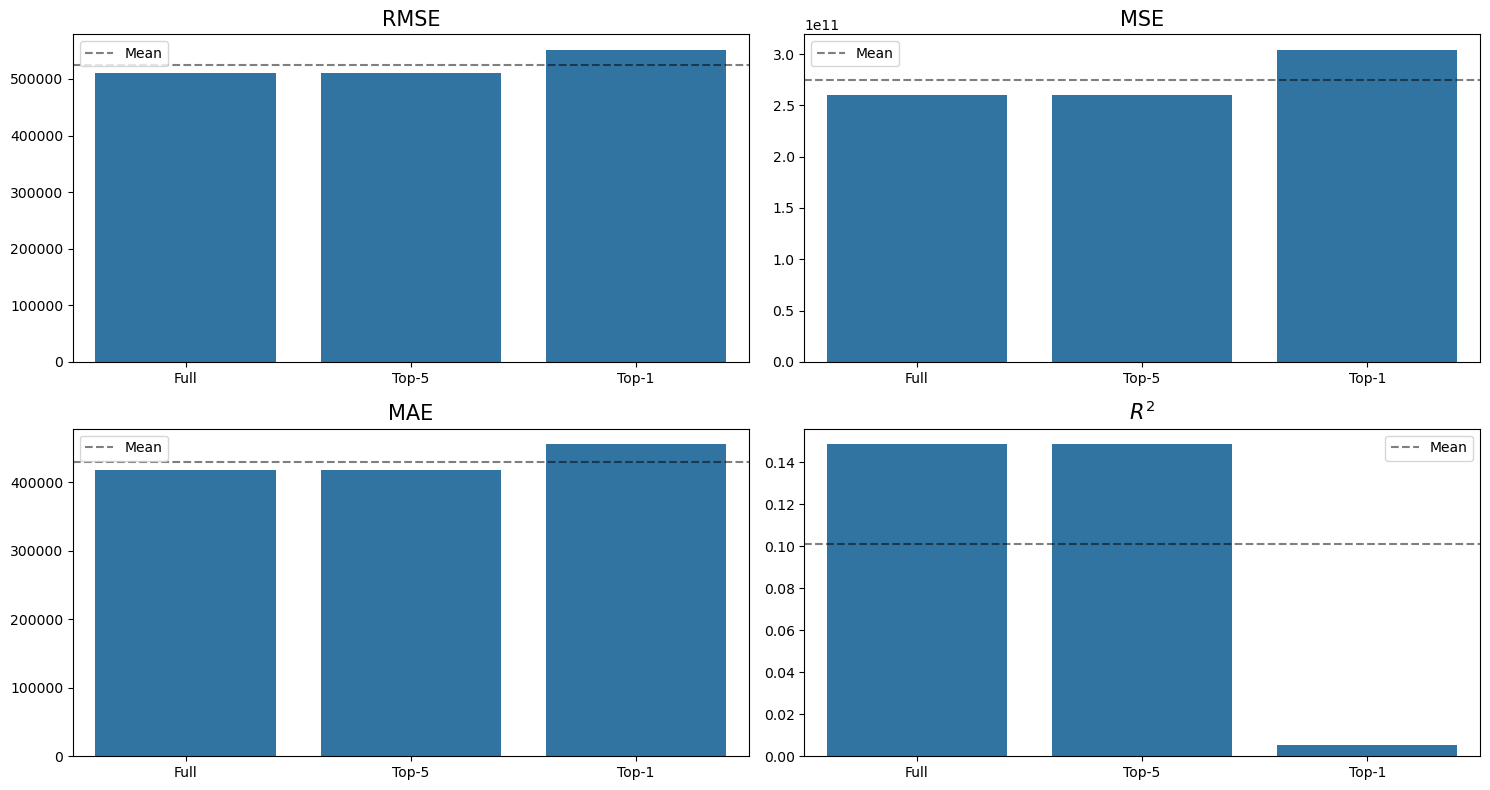

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extract the performance metrics from the DataFrames
RMSEs = [lr_full_scores.loc['Performance Metrics', 'RMSE'], lr_5_scores.loc['Performance Metrics', 'RMSE'], lr_scores.loc['Performance Metrics', 'RMSE']]
MSEs  = [lr_full_scores.loc['Performance Metrics', 'MSE'], lr_5_scores.loc['Performance Metrics', 'MSE'], lr_scores.loc['Performance Metrics', 'MSE']]
MAEs  = [lr_full_scores.loc['Performance Metrics', 'MAE'], lr_5_scores.loc['Performance Metrics', 'MAE'], lr_scores.loc['Performance Metrics', 'MAE']]
R2s   = [lr_full_scores.loc['Performance Metrics', 'R-sq'], lr_5_scores.loc['Performance Metrics', 'R-sq'], lr_scores.loc['Performance Metrics', 'R-sq']]

# Setting figure size for subplots
plt.figure(figsize=(15, 8))

# Plot for RMSE
plt.subplot(2, 2, 1)
sns.barplot(x=DATA_SIZE, y=RMSEs)
plt.title("RMSE", fontsize=15)
plt.axhline(np.mean(RMSEs), color='k', linestyle='--', alpha=0.5, label='Mean')
plt.legend()

# Plot for MSE
plt.subplot(2, 2, 2)
sns.barplot(x=DATA_SIZE, y=MSEs)
plt.title("MSE", fontsize=15)
plt.axhline(np.mean(MSEs), color='k', linestyle='--', alpha=0.5, label='Mean')
plt.legend()

# Plot for MAE
plt.subplot(2, 2, 3)
sns.barplot(x=DATA_SIZE, y=MAEs)
plt.title("MAE", fontsize=15)
plt.axhline(np.mean(MAEs), color='k', linestyle='--', alpha=0.5, label='Mean')
plt.legend()

# Plot for R-squared (R^2)
plt.subplot(2, 2, 4)
sns.barplot(x=DATA_SIZE, y=R2s)
plt.title("$R^2$", fontsize=15)
plt.axhline(np.mean(R2s), color='k', linestyle='--', alpha=0.5, label='Mean')
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


**Decision Tree model to validate best features** 

In [216]:
# Train and evaluate Decision Tree Regression model: full set
dt_full = DecisionTreeRegressor()
dt_full.fit(X_train_full, y_train_full)
dt_full_pred = dt_full.predict(X_test_full)
dt_full_scores = perf_cal(y_test_full, dt_full_pred)

# Print performance scores
print("Decision Tree Regression Performance Scores:")

print(dt_full_scores)

Decision Tree Regression Performance Scores:
                              RMSE           MSE           MAE      R-sq
Performance Metrics  176867.050838  3.128195e+10  91403.201373  0.897649


In [217]:
# Decision Tree Regression: top 5
dt_5 = DecisionTreeRegressor()

# Train the Model
dt_5.fit(X_train_5, y_train_5)

# Make Predictions
dt_5_pred = dt_5.predict(X_test_5)

# Evaluate Performance
dt_5_scores = perf_cal(y_test_5, dt_5_pred)

# Display Performance Metrics
print("Decision Tree Regression Performance Metrics (Subset 5)")
print(dt_5_scores)

Decision Tree Regression Performance Metrics (Subset 5)
                              RMSE           MSE           MAE      R-sq
Performance Metrics  177303.109766  3.143639e+10  91300.908153  0.897144


In [218]:
# Decision Tree Regression:  Most Important Feature
dt = DecisionTreeRegressor()

# Train the model
dt.fit(X_train, y_train)

# Make predictions on the test set
dt_pred = dt.predict(X_test)

# Evaluate the model's performance
dt_scores = perf_cal(y_test, dt_pred)

# Print the performance metrics
print("Decision Tree Regression Performance Metrics (Subset 1)")
print(dt_scores)

Decision Tree Regression Performance Metrics (Subset 1)
                              RMSE           MSE            MAE      R-sq
Performance Metrics  546156.474107  2.982869e+11  451210.781726  0.024041


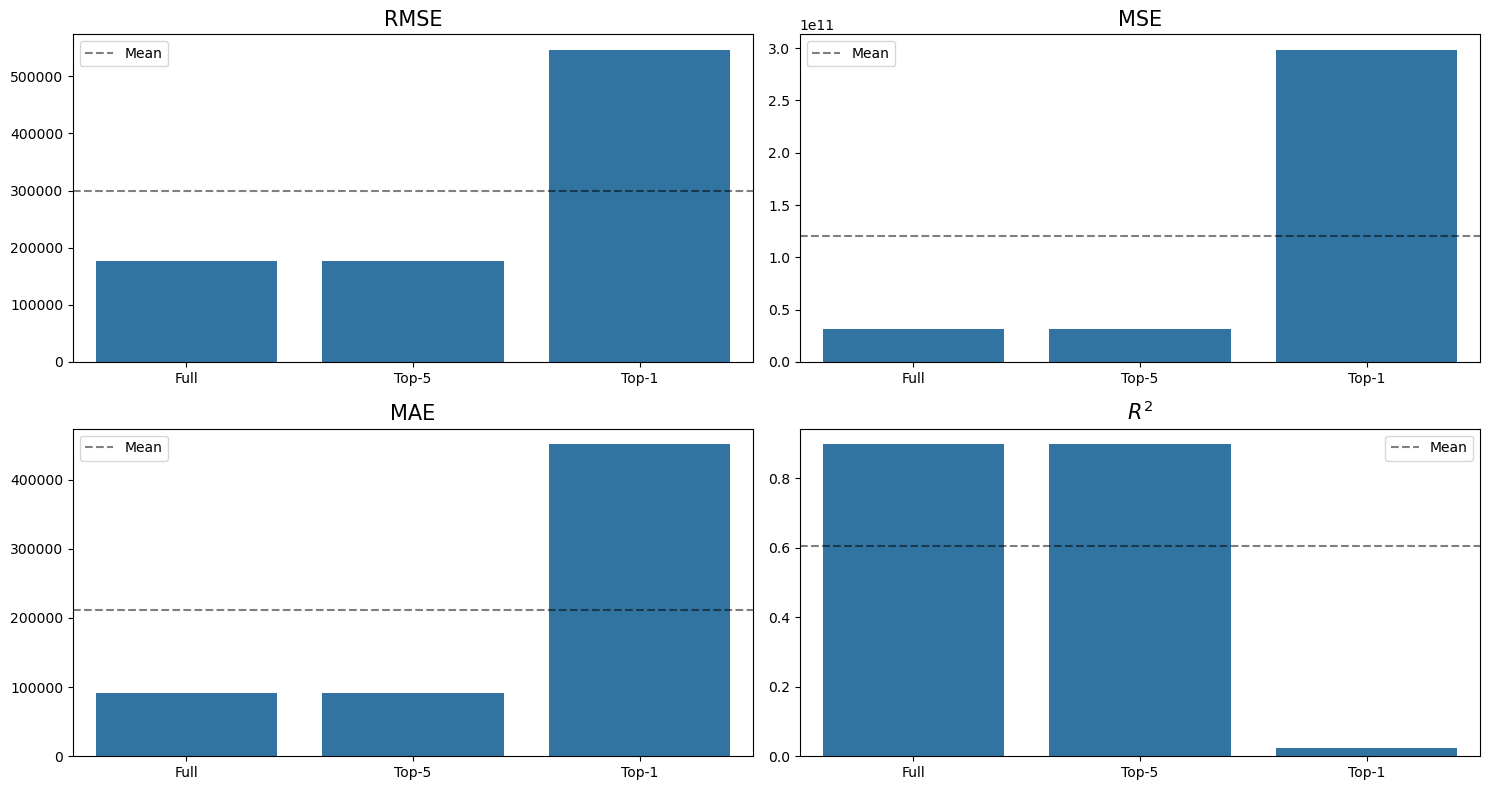

In [219]:

# Extract the performance metrics from the DataFrames
RMSEs = [dt_full_scores.loc['Performance Metrics', 'RMSE'], dt_5_scores.loc['Performance Metrics', 'RMSE'], dt_scores.loc['Performance Metrics', 'RMSE']]
MSEs  = [dt_full_scores.loc['Performance Metrics', 'MSE'], dt_5_scores.loc['Performance Metrics', 'MSE'], dt_scores.loc['Performance Metrics', 'MSE']]
MAEs  = [dt_full_scores.loc['Performance Metrics', 'MAE'], dt_5_scores.loc['Performance Metrics', 'MAE'], dt_scores.loc['Performance Metrics', 'MAE']]
R2s   = [dt_full_scores.loc['Performance Metrics', 'R-sq'], dt_5_scores.loc['Performance Metrics', 'R-sq'], dt_scores.loc['Performance Metrics', 'R-sq']]

# Create the figure and subplots
plt.figure(figsize=(15,8))

# Plot for RMSE
plt.subplot(2, 2, 1)
sns.barplot(x=DATA_SIZE, y=RMSEs)
plt.title("RMSE", fontsize=15)
plt.axhline(np.mean(RMSEs), color='k', linestyle='--', alpha=0.5, label='Mean')
plt.legend()

# Plot for MSE
plt.subplot(2, 2, 2)
sns.barplot(x=DATA_SIZE, y=MSEs)
plt.title("MSE", fontsize=15)
plt.axhline(np.mean(MSEs), color='k', linestyle='--', alpha=0.5, label='Mean')
plt.legend()

# Plot for MAE
plt.subplot(2, 2, 3)
sns.barplot(x=DATA_SIZE, y=MAEs)
plt.title("MAE", fontsize=15)
plt.axhline(np.mean(MAEs), color='k', linestyle='--', alpha=0.5, label='Mean')
plt.legend()

# Plot for R-squared (R^2)
plt.subplot(2, 2, 4)
sns.barplot(x=DATA_SIZE, y=R2s)
plt.title("$R^2$", fontsize=15)
plt.axhline(np.mean(R2s), color='k', linestyle='--', alpha=0.5, label='Mean')
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Model Selection
### Carlos Iturralde & Vikash Sinha 
Above selecting our best feature set, we shall be evaluating the best model.

**Decision Tree Regression**

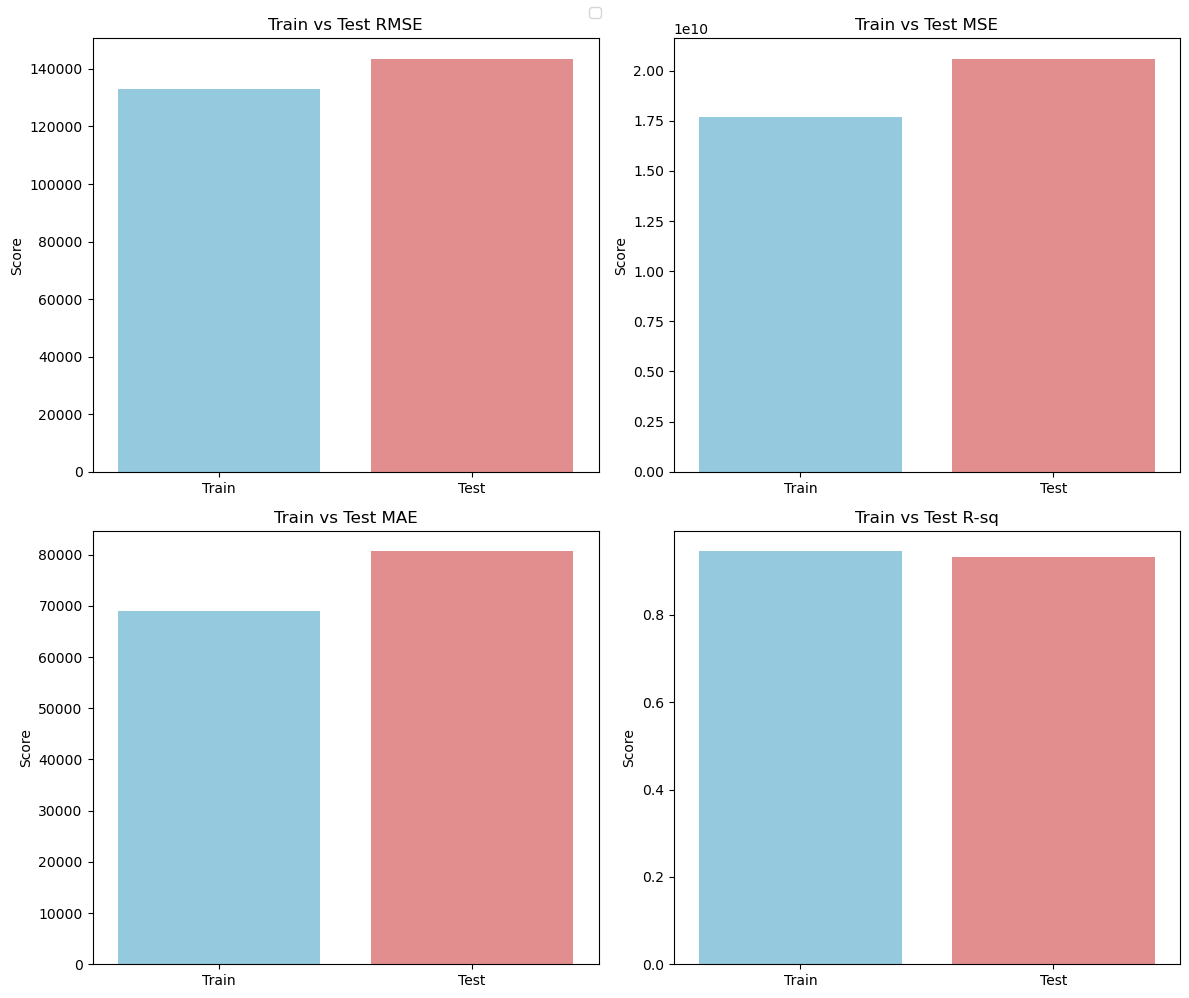

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Decision Tree Regression
dtr = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=10)

# Train Model
dtr.fit(X_train_full, y_train_full)

# Training Performance
y_pred_train = dtr.predict(X_train_full)
dtr_train_scores = perf_cal(y_train_full, y_pred_train)

# Testing Performance
y_pred_test = dtr.predict(X_test_full)
dtr_test_scores = perf_cal(y_test_full, y_pred_test)

# Create a DataFrame to hold the comparison of train and test scores for plotting
comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'R-sq'] * 2,  # Repeat metric names twice, once for Train and once for Test
    'Score': [
        dtr_train_scores.loc['Performance Metrics', 'RMSE'], dtr_train_scores.loc['Performance Metrics', 'MSE'],
        dtr_train_scores.loc['Performance Metrics', 'MAE'], dtr_train_scores.loc['Performance Metrics', 'R-sq'],
        dtr_test_scores.loc['Performance Metrics', 'RMSE'], dtr_test_scores.loc['Performance Metrics', 'MSE'],
        dtr_test_scores.loc['Performance Metrics', 'MAE'], dtr_test_scores.loc['Performance Metrics', 'R-sq']
    ],
    'Type': ['Train'] * 4 + ['Test'] * 4  # First four entries are Train, next four are Test
})

# Define custom colors for Train and Test bars
colors = {'Train': 'skyblue', 'Test': 'lightcoral'}


# Create subplots for each metric
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# List of metrics to plot
metrics = ['RMSE', 'MSE', 'MAE', 'R-sq']

# Iterate over metrics and create a subplot for each
for i, metric in enumerate(metrics):
    sns.barplot(
        x='Type', 
        y='Score', 
        data=comparison_df[comparison_df['Metric'] == metric], 
        ax=axs[i // 2, i % 2], 
        palette=colors,  # Custom palette for Train and Test
        dodge=False  # Prevent bars from being dodged
    )
    axs[i // 2, i % 2].set_title(f"Train vs Test {metric}")
    axs[i // 2, i % 2].set_ylabel("Score")
    axs[i // 2, i % 2].set_xlabel("")

# Add a single legend for the whole figure
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

# Adjust layout
plt.tight_layout()
plt.show()


**Random Forest Regression**

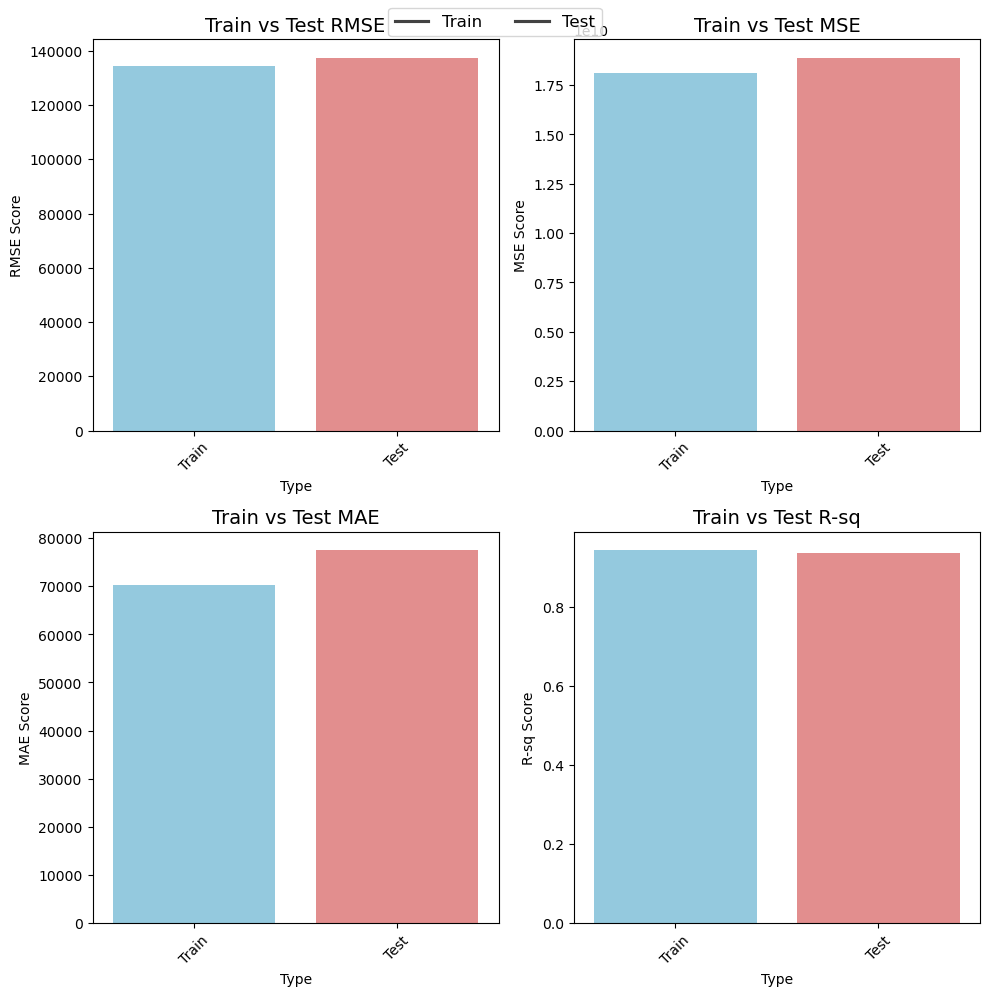

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

SCORE_NAMES = ['RMSE', 'MSE', 'MAE', 'R-sq']

# Random Forest Regression
rfr = RandomForestRegressor(n_estimators=20, min_samples_leaf=10, min_samples_split=10)

# Train Model
rfr.fit(X_train_full, y_train_full)

# Predictions on training and testing sets
y_pred_train = rfr.predict(X_train_full)
y_pred_test = rfr.predict(X_test_full)

# Calculate training and testing performance
rfr_train_scores = perf_cal(y_train_full, y_pred_train)
rfr_test_scores = perf_cal(y_test_full, y_pred_test)

# Extract scores for plotting
train_scores = [rfr_train_scores.loc['Performance Metrics', name] for name in SCORE_NAMES]
test_scores = [rfr_test_scores.loc['Performance Metrics', name] for name in SCORE_NAMES]
score_names = SCORE_NAMES

# Create DataFrame for seaborn
df_plot = pd.DataFrame({
    'Metric': score_names * 2,  # Repeat score names for train and test
    'Score': train_scores + test_scores,  # Combine train and test scores
    'Type': ['Train'] * len(train_scores) + ['Test'] * len(test_scores)  # Label for train and test
})

# Set up the figure for subplots
plt.figure(figsize=(10, 10))

# Iterate through the score names and plot each as a separate subplot
for index, name in enumerate(SCORE_NAMES):
    plt.subplot(2, 2, index + 1)
    
    # Filter data for the current metric
    data_to_plot = df_plot[df_plot['Metric'] == name]
    
    # Use seaborn's barplot
    sns.barplot(
        x='Type', 
        y='Score', 
        data=data_to_plot, 
        palette={'Train': 'skyblue', 'Test': 'lightcoral'}, 
        dodge=False
    )
    
    # Title and aesthetic adjustments
    plt.title(f"Train vs Test {name}", fontsize=14)
    plt.ylabel(f"{name} Score")
    plt.xticks(rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Add a single legend for the figure
plt.figlegend(labels=['Train', 'Test'], loc='upper center', ncol=2, fontsize=12)

# Display the plot
plt.show()


**Linear Regression**

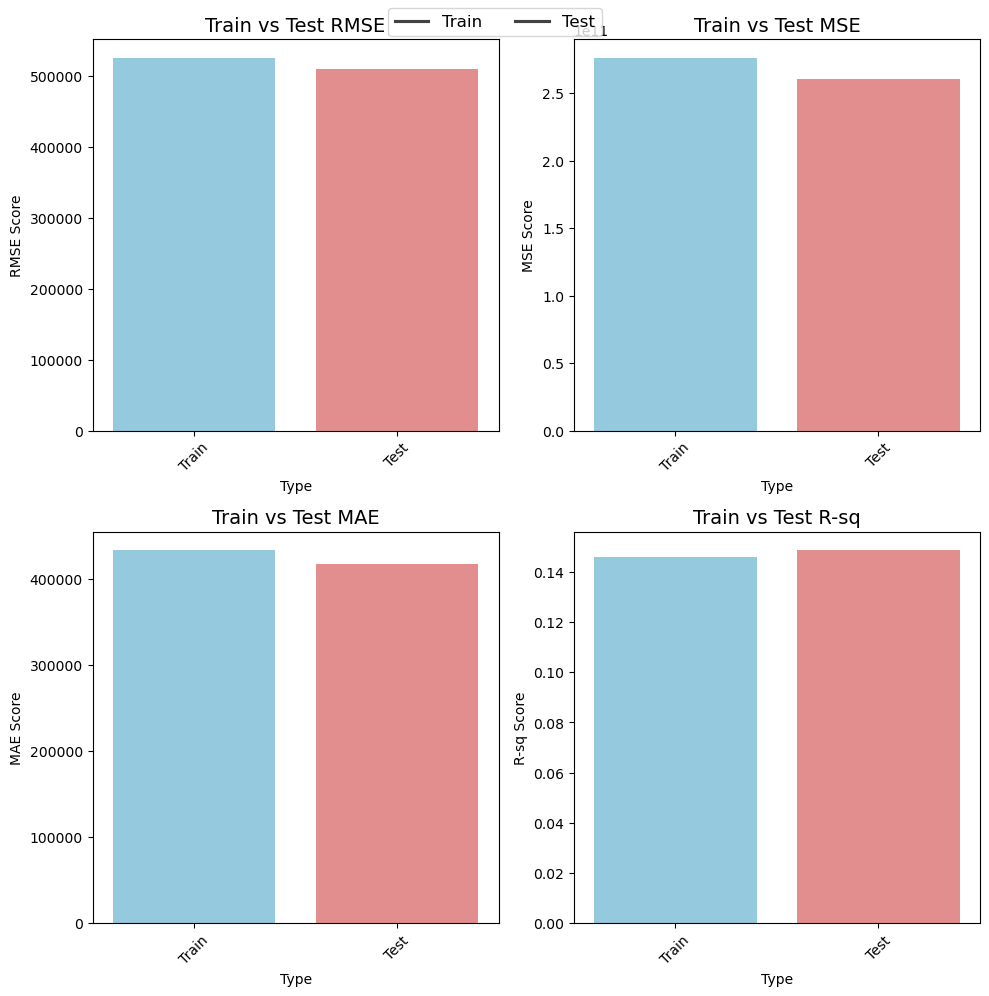

In [226]:
# Linear Regression

# Linear Regression
lr = LinearRegression()

# Train Model
lr.fit(X_train_full, y_train_full)

# Predictions on training and testing sets
y_pred_train = lr.predict(X_train_full)
y_pred_test = lr.predict(X_test_full)

# Calculate training and testing performance
lr_train_scores = perf_cal(y_train_full, y_pred_train)
lr_test_scores = perf_cal(y_test_full, y_pred_test)

# Extract scores for plotting
train_scores = [lr_train_scores.loc['Performance Metrics', name] for name in SCORE_NAMES]
test_scores = [lr_test_scores.loc['Performance Metrics', name] for name in SCORE_NAMES]

# Create DataFrame for seaborn
df_plot = pd.DataFrame({
    'Metric': SCORE_NAMES * 2,  # Repeat score names for train and test
    'Score': train_scores + test_scores,  # Combine train and test scores
    'Type': ['Train'] * len(train_scores) + ['Test'] * len(test_scores)  # Label for train and test
})

# Set up the figure for subplots
plt.figure(figsize=(10, 10))

# Iterate through the score names and plot each as a separate subplot
for index, name in enumerate(SCORE_NAMES):
    plt.subplot(2, 2, index + 1)
    
    # Filter data for the current metric
    data_to_plot = df_plot[df_plot['Metric'] == name]
    
    # Use seaborn's barplot without legend parameter
    sns.barplot(
        x='Type', 
        y='Score', 
        data=data_to_plot, 
        palette={'Train': 'skyblue', 'Test': 'lightcoral'}, 
        dodge=False
    )
    
    # Title and aesthetic adjustments
    plt.title(f"Train vs Test {name}", fontsize=14)
    plt.ylabel(f"{name} Score")
    plt.xticks(rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Add a single legend for the figure
plt.figlegend(labels=['Train', 'Test'], loc='upper center', ncol=2, fontsize=12)

# Display the plot
plt.show()




#### Model evaluation and summary of results 


In [228]:
import time

# List of models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=20, min_samples_leaf=10, min_samples_split=10),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, min_samples_split=10),
    'Linear Regression': LinearRegression()
}

# Initialize a dictionary to store results
results = {}
execution_times = {}  # To store execution times

# Iterate over each model
for model_name, model in models.items():
    # Measure the start time
    start_time = time.time()
    
    # Train model
    model.fit(X_train_full, y_train_full)

    # Measure the end time and calculate execution time
    execution_time = time.time() - start_time
    execution_times[model_name] = execution_time
    
    # Predictions on train and test sets
    y_pred_train = model.predict(X_train_full)
    y_pred_test = model.predict(X_test_full)
    
    # Calculate performance on train and test sets
    train_scores = perf_cal(y_train_full, y_pred_train)
    test_scores = perf_cal(y_test_full, y_pred_test)
    
    # Store the results in a DataFrame
    results[model_name] = pd.concat([train_scores, test_scores], keys=['Train', 'Test'])

# Create a final DataFrame to compare all models
comparison_df = pd.concat(results, axis=1)
comparison_df.columns = comparison_df.columns.swaplevel(0, 1)
comparison_df = comparison_df.sort_index(axis=1)

# Display the final comparison matrix
print(comparison_df)

# Print the execution times for each model
print("\nModel Execution Times (in seconds):")
for model_name, exec_time in execution_times.items():
    print(f"{model_name}: {exec_time:.4f} seconds")


                                    MAE                                  \
                          Decision Tree Linear Regression Random Forest   
Train Performance Metrics  76216.438621     433363.765027  67561.468629   
Test  Performance Metrics  84827.378472     417285.270097  75990.350091   

                                    MSE                                  \
                          Decision Tree Linear Regression Random Forest   
Train Performance Metrics  1.957012e+10      2.761116e+11  1.704743e+10   
Test  Performance Metrics  2.199998e+10      2.602211e+11  1.853560e+10   

                                   R-sq                                  \
                          Decision Tree Linear Regression Random Forest   
Train Performance Metrics      0.939473          0.146037      0.947275   
Test  Performance Metrics      0.928019          0.148588      0.939354   

                                    RMSE                                   
                     

## Cross-validation of models
### Carlos Iturralde

Cross validation for Decision Tree Regressor

In [231]:

from sklearn.model_selection import GridSearchCV, cross_val_score

# Define the grid of hyperparameters to search for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples at a leaf node
}

# Set up GridSearchCV for Decision Tree with 5-fold cross-validation
grid_search_dt = GridSearchCV(estimator=dtr, param_grid=param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Train the DecisionTreeRegressor using grid search
grid_search_dt.fit(X_train, y_train)

# Get the best parameters from grid search for Decision Tree
best_params_dt = grid_search_dt.best_params_
print("Best parameters for Decision Tree: ", best_params_dt)

# Train the best model found using cross-validation
best_dt = grid_search_dt.best_estimator_

# Cross-validation scores (MSE)
cv_scores_dt = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Display Cross-validation scores
print("Cross-validation MSE scores (Decision Tree): ", -cv_scores_dt)
print("Average CV MSE (Decision Tree): ", -cv_scores_dt.mean())

# Test Set Evaluation
y_pred_dt = best_dt.predict(X_test)
test_mse_dt = mean_squared_error(y_test, y_pred_dt)
test_rmse_dt = np.sqrt(test_mse_dt)
test_r2_dt = r2_score(y_test, y_pred_dt)

print(f"Test RMSE (Decision Tree): {test_rmse_dt}")
print(f"Test R^2 (Decision Tree): {test_r2_dt}")


Best parameters for Decision Tree:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Cross-validation MSE scores (Decision Tree):  [3.55937209e+11 2.92570268e+11 3.21635166e+11 3.19014188e+11
 3.19344522e+11]
Average CV MSE (Decision Tree):  321700270372.7667
Test RMSE (Decision Tree): 546156.4741073805
Test R^2 (Decision Tree): 0.024040956597148


**Cross validation for Random Regressor**

In [233]:
# Cross-validation for Random Forest Regression
cv_scores_rfr = cross_val_score(rfr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Display Cross-validation scores
print("Cross-validation MSE scores (Random Forest Regression): ", -cv_scores_rfr)
print("Average CV MSE (Random Forest Regression): ", -cv_scores_rfr.mean())

# Train the model and test on test set
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

# Test Set Evaluation
test_mse_rfr = mean_squared_error(y_test, y_pred_rfr)
test_rmse_rfr = np.sqrt(test_mse_rfr)
test_r2_rfr = r2_score(y_test, y_pred_rfr)

print(f"Test RMSE (Random Forest Regression): {test_rmse_rfr}")
print(f"Test R^2 (Random Forest Regression): {test_r2_rfr}")

Cross-validation MSE scores (Random Forest Regression):  [3.56583151e+11 2.91952351e+11 3.21699638e+11 3.19161471e+11
 3.19694374e+11]
Average CV MSE (Random Forest Regression):  321818197016.6923
Test RMSE (Random Forest Regression): 546163.2072979267
Test R^2 (Random Forest Regression): 0.024016892582446547


## Time Series Modeling for Walmart Sales Data
### Vikash Sinha
To perform time series modeling, we need to reshape the data into a format suitable for time-series forecasting. This involves setting the date as the index and working on aggregated sales data. Below is a step-by-step implementation:
We shall beb using data for one single store. Here we are selecting Store No 20 to test and evaluate the Model.  

#### 1. Preprocessing for Time Series

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [237]:
# Load data

# Filter the data for Store 20
store_20_data = sales_df[sales_df['Store'] == 20]


In [238]:
# Ensure 'Date' is in datetime format and set as index
store_20_data['Date'] = pd.to_datetime(store_20_data['Date'])
store_20_data.set_index('Date', inplace=True)
##Convert Sales value to float
store_20_data['Weekly_Sales'] = store_20_data['Weekly_Sales'].replace('[\$,]', '', regex=True).astype(float)


In [239]:
# Aggregate weekly sales for Store 20
weekly_sales_store_20 = store_20_data['Weekly_Sales'].resample('W').sum()

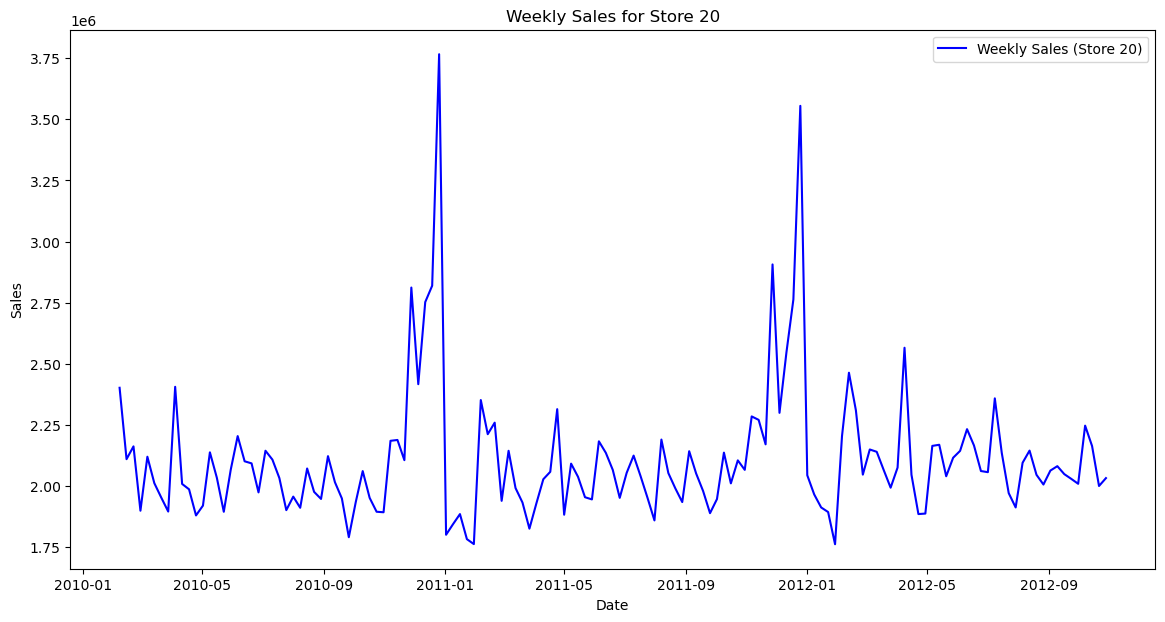

In [240]:
# Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(weekly_sales_store_20, label='Weekly Sales (Store 20)', color='blue')
plt.title('Weekly Sales for Store 20')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#### 2. Decompose Time Series

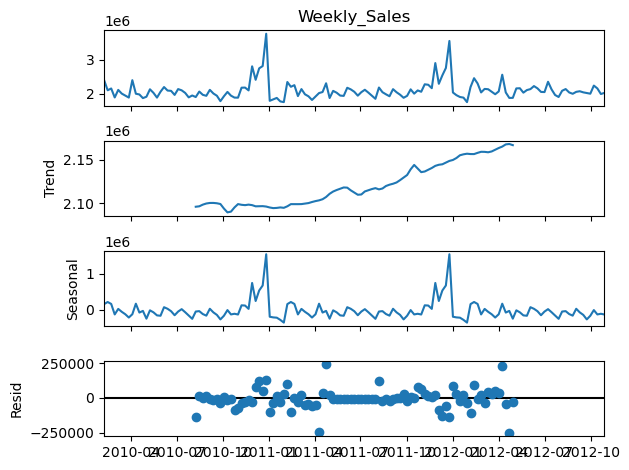

In [242]:
# Decompose the time series for Store 20
decomposition = seasonal_decompose(weekly_sales_store_20, model='additive', period=52)

# Plot the decomposition
decomposition.plot()
plt.show()

#### 3. Train-Test Split

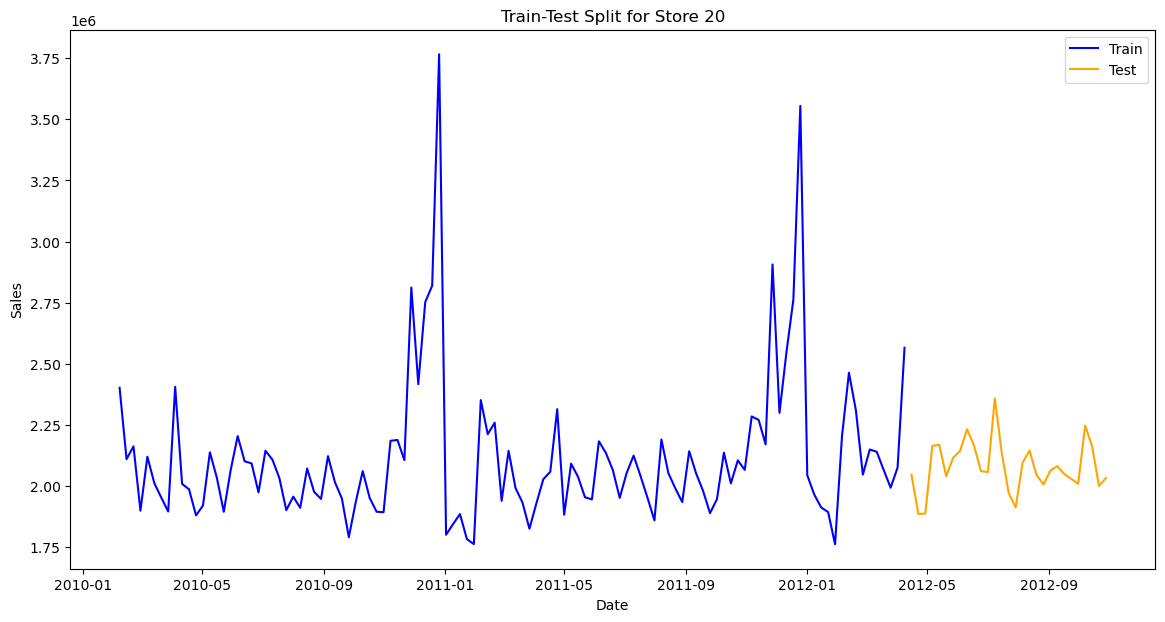

In [244]:
# Split the data into train and test sets (80% train, 20% test)
split_index = int(len(weekly_sales_store_20) * 0.8)
train, test = weekly_sales_store_20[:split_index], weekly_sales_store_20[split_index:]

# Plot the train-test split
plt.figure(figsize=(14, 7))
plt.plot(train, label='Train', color='blue')
plt.plot(test, label='Test', color='orange')
plt.title('Train-Test Split for Store 20')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


#### 4. Build ARIMA Model

In [246]:
from statsmodels.tsa.arima.model import ARIMA

# Build ARIMA model for Store 20
arima_model = ARIMA(train, order=(2, 1, 2))  # (p, d, q) parameters can be tuned
arima_result = arima_model.fit()

# Summary of ARIMA model
print(arima_result.summary())

# Forecast on test set
forecast = arima_result.forecast(steps=len(test))


                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1581.307
Date:                Tue, 10 Dec 2024   AIC                           3172.614
Time:                        18:33:14   BIC                           3186.251
Sample:                    02-07-2010   HQIC                          3178.147
                         - 04-08-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3184      0.278     -1.143      0.253      -0.864       0.227
ar.L2          0.4664      0.143      3.260      0.001       0.186       0.747
ma.L1         -0.1808      0.280     -0.646      0.5

#### 5. Evaluate ARIMA Performance

ARIMA Model Performance for Store 20:
Root Mean Squared Error (RMSE): 178149.55
R^2 Score: -1.93


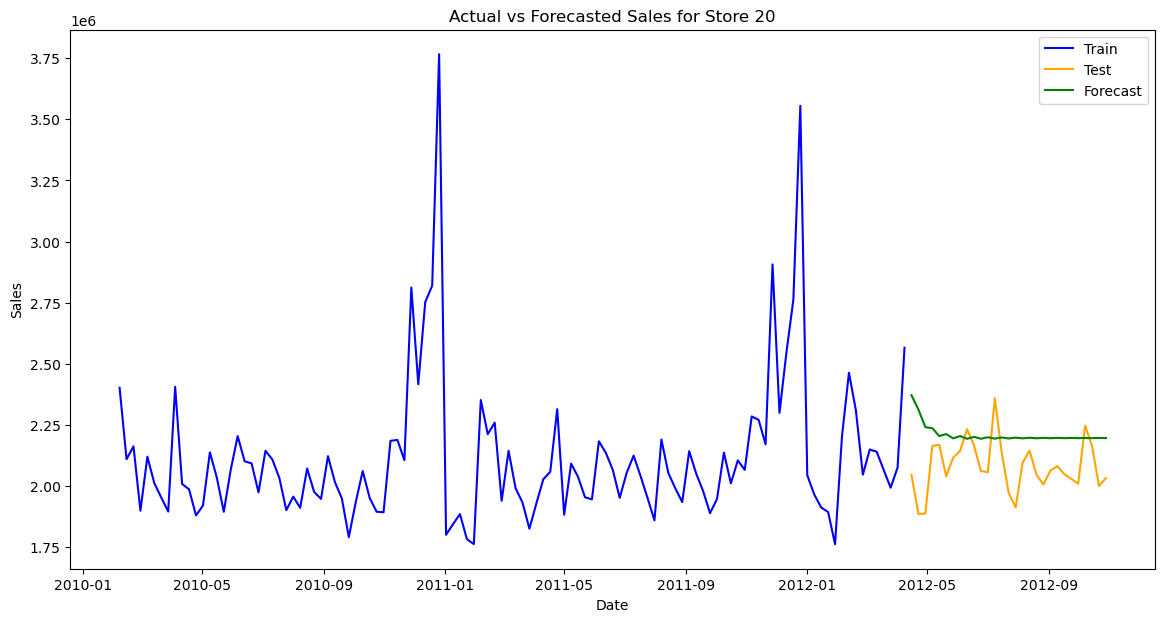

In [248]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the ARIMA model
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print(f'ARIMA Model Performance for Store 20:')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Plot actual vs forecasted sales
plt.figure(figsize=(14, 7))
plt.plot(train, label='Train', color='blue')
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title('Actual vs Forecasted Sales for Store 20')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


#### 6. Seasonal ARIMA (SARIMA)

In [250]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build SARIMA model
sarima_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 52))  # Seasonal order is (p, d, q, s)
sarima_result = sarima_model.fit()

# Forecast using SARIMA
sarima_forecast = sarima_result.forecast(steps=len(test))

# Evaluate SARIMA model
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
sarima_r2 = r2_score(test, sarima_forecast)

print(f'SARIMA Model Performance for Store 20:')
print(f'Root Mean Squared Error (RMSE): {sarima_rmse:.2f}')
print(f'R^2 Score: {sarima_r2:.2f}')


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00277D+00    |proj g|=  5.42682D+00

At iterate    5    f=  7.18275D+00    |proj g|=  9.44964D-02

At iterate   10    f=  7.16732D+00    |proj g|=  6.52588D-02

At iterate   15    f=  7.14728D+00    |proj g|=  5.99646D-02

At iterate   20    f=  7.14172D+00    |proj g|=  7.18115D-03

At iterate   25    f=  7.13718D+00    |proj g|=  1.02474D-02

At iterate   30    f=  7.13695D+00    |proj g|=  7.49389D-04

At iterate   35    f=  7.13686D+00    |proj g|=  8.67241D-03

At iterate   40    f=  7.13671D+00    |proj g|=  6.83118D-04

At iterate   45    f=  7.13670D+00    |proj g|=  1.64797D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

#### 7. Compare ARIMA and SARIMA


    Model           RMSE        R^2
0   ARIMA  178149.551934  -1.929639
1  SARIMA  408569.981862 -14.409111


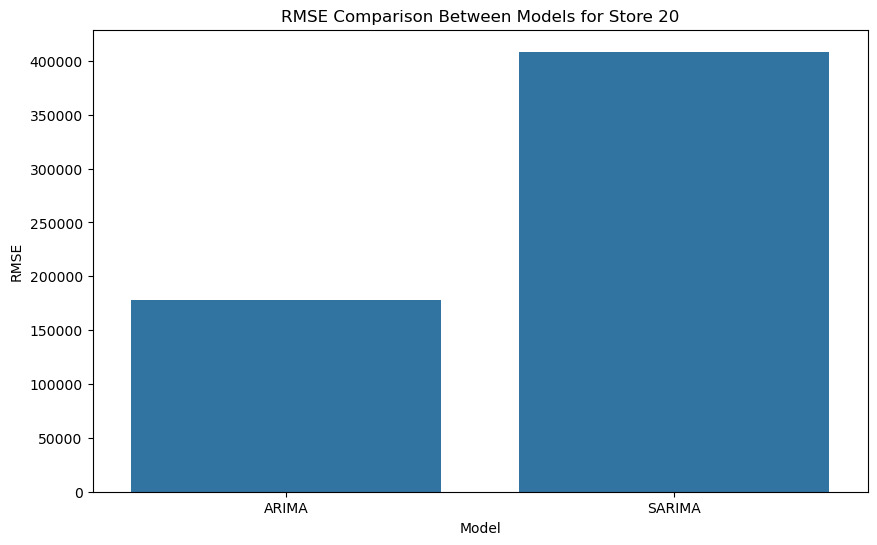

In [252]:
# Compare ARIMA and SARIMA models
results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'RMSE': [rmse, sarima_rmse],
    'R^2': [r2, sarima_r2]
})

print(results)

# Plot RMSE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('RMSE Comparison Between Models for Store 20')
plt.show()


#### Best Time Series model:
From Above ARIMA is best performer model and can be used to Forecast for future date

#### 6. Forecast for Future Dates
Extend the model to forecast sales for future dates beyond the test set.
Specify the number of steps to forecast (e.g., weeks, months, etc.).

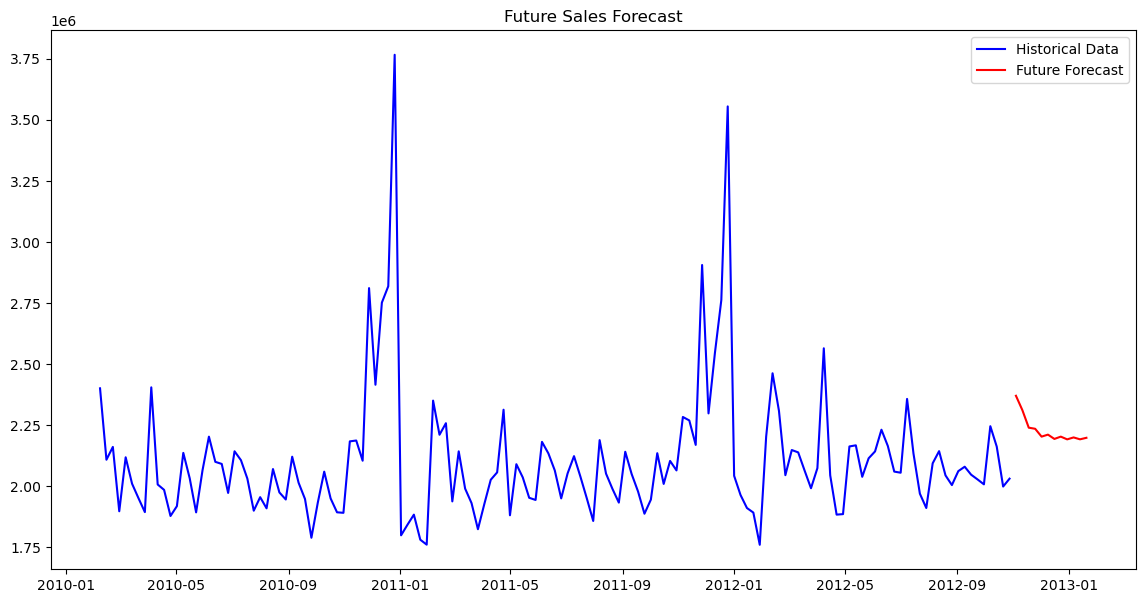

In [255]:
# Forecast for future dates (e.g. one quarter, next 12 weeks)
future_steps = 12
future_forecast = arima_result.forecast(steps=future_steps)

# Generate future dates
future_dates = pd.date_range(start=weekly_sales_store_20.index[-1], periods=future_steps + 1, freq='W')[1:]

# Create a DataFrame for visualization
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_forecast})
future_df.set_index('Date', inplace=True)

# Plot future forecast
plt.figure(figsize=(14, 7))
plt.plot(weekly_sales_store_20, label='Historical Data', color='blue')
plt.plot(future_df, label='Future Forecast', color='red')
plt.title('Future Sales Forecast')
plt.legend()
plt.show()


In [256]:
future_df.head(future_steps)

,Forecast
Date,
2012-11-04,2.370922e+06
2012-11-11,2.312276e+06
2012-11-18,2.240302e+06
2012-11-25,2.235865e+06
2012-12-02,2.203707e+06
2012-12-09,2.211877e+06
2012-12-16,2.194275e+06
2012-12-23,2.203691e+06
2012-12-30,2.192483e+06


## Ola Olasanoye

## Walmart Sales Prediction using LSTM Deep Learning Model

## Overview
This section implements a Long Short-Term Memory (LSTM) neural network to predict Walmart store sales. The model captures long-term dependencies and patterns in the sales data across different stores.

## Model Architecture
1. Input Layer: Shaped for sequence data (4 time steps, 10 features)
2. LSTM Layers:
   - First LSTM: 64 units with ReLU activation
   - Second LSTM: 32 units with ReLU activation
3. Dropout Layers (0.2) for regularization
4. Dense Layers:
   - Hidden Dense: 16 units with ReLU
   - Output Dense: 1 unit (prediction)

## Implementation Steps
1. Data Preprocessing:
   - Clean sales data (remove $ and commas)
   - Convert categorical variables to numeric
   - Scale features using MinMaxScaler
   - Create sequences for time series prediction

2. Model Training:
   - Split: 80% training, 20% testing
   - Sequence length: 4 weeks of historical data
   - Batch size: 32
   - Epochs: 50
   - Loss function: Mean Squared Error
   - Optimizer: Adam with learning rate 0.001

3. Evaluation Metrics:
   - Mean Absolute Error (MAE)
   - Mean Squared Error (MSE)
   - Root Mean Squared Error (RMSE)
   - Mean Absolute Percentage Error (MAPE)

## Results and Visualizations
- Training and validation loss curves
- Actual vs predicted sales comparison
- Error metrics analysis
- Future sales predictions


In [258]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns



Data preprocessing

In [260]:
# Data preprocessing
def preprocess_sales_data(df):
    # Convert Weekly_Sales to numeric, removing '$' and ',' and converting to float
    df['Weekly_Sales'] = df['Weekly_Sales'].str.replace('$', '').str.replace(',', '').str.strip().astype(float)
    
    # Convert Day of the Week to numeric
    day_mapping = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
    df['Day_of_Week_Num'] = df['Day of the Week'].map(day_mapping)
    
    # Select features for model
    features = ['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                'Holiday_Flag', 'Day_of_Week_Num', 'Day', 'Month', 'Year']
    target = 'Weekly_Sales'
    
    return df, features, target

# Create sequences for LSTM
def create_sequences(data, target_data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(target_data[i + seq_length])
    return np.array(X), np.array(y)

# Prepare your data
df = sales_df.copy()
df, features, target = preprocess_sales_data(df)

# Scale the features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features and target
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

# Create sequences
sequence_length = 4  # Using 4 weeks of historical data to predict the next week
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (5144, 4, 10)
Test set shape: (1287, 4, 10)


Build LSTM model

In [262]:
# Build LSTM model with explicit input layer
from tensorflow.keras.layers import Input

def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = LSTM(64, activation='relu', return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model

# Create and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, n_features)
model = build_lstm_model(input_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4, 64)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,161 (125.63 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0359 - mae: 0.1502 - val_loss: 0.0258 - val_mae: 0.1340
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - mae: 0.1242 - val_loss: 0.0253 - val_mae: 0.1334
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - mae: 0.1217 - val_loss: 0.0253 - val_mae: 0.1353
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mae: 0.1228 - val_loss: 0.0241 - val_mae: 0.1309
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 - mae: 0.1186 - val_loss: 0.0245 - val_mae: 0.1250
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - mae: 0.1136 - val_loss: 0.0206 - val_mae: 0.1150
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mae: 0.1055 - val_loss: 0.0191 - val_mae: 0.1075
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - mae: 0.0992 - val_loss: 0.0174 - val_mae: 0.1007
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

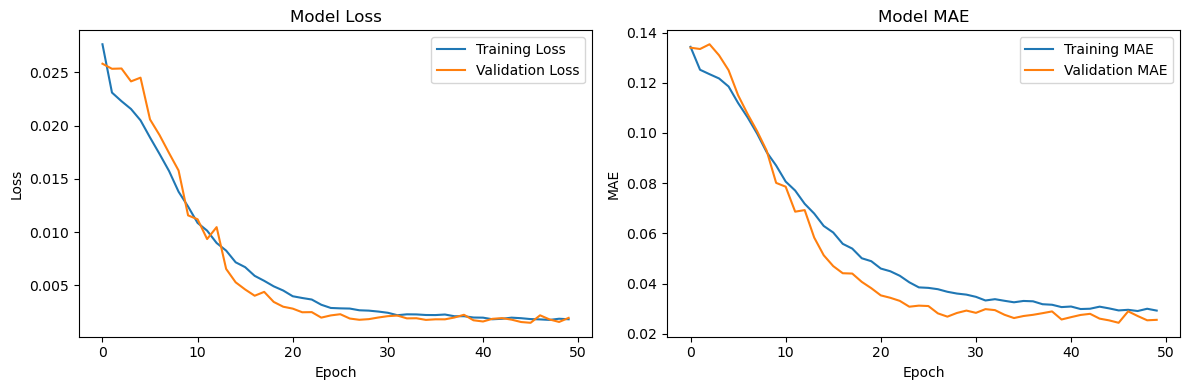

In [264]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Make predictions

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Squared Error: $22,651,825,876.08
Root Mean Squared Error: $150,505.24
Mean Absolute Error: $86,705.95
Mean Absolute Percentage Error: 8.45%


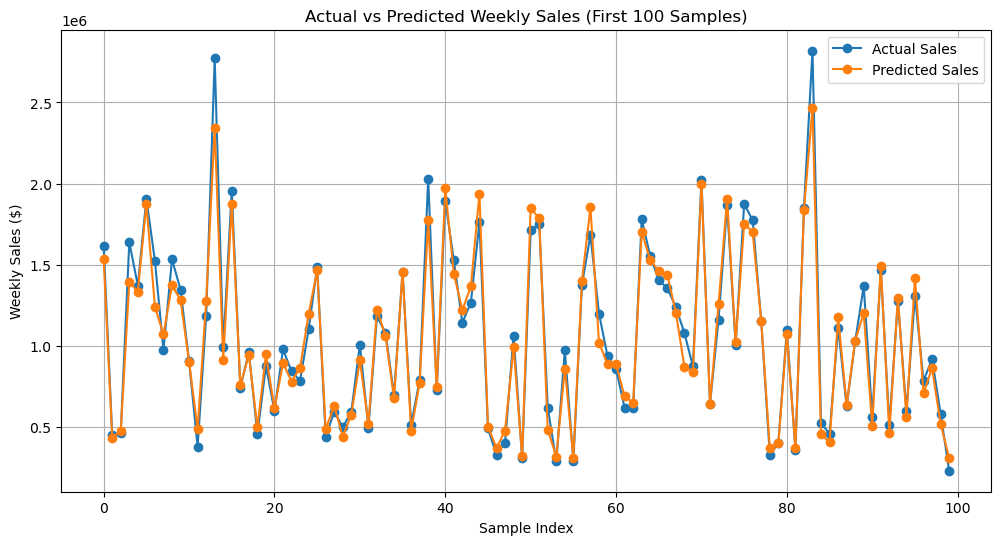

In [266]:
# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate metrics
mse = np.mean((y_pred - y_test_actual) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred - y_test_actual))
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

print(f'Mean Squared Error: ${mse:,.2f}')
print(f'Root Mean Squared Error: ${rmse:,.2f}')
print(f'Mean Absolute Error: ${mae:,.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:100], label='Actual Sales', marker='o')
plt.plot(y_pred[:100], label='Predicted Sales', marker='o')
plt.title('Actual vs Predicted Weekly Sales (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.grid(True)
plt.show()

Function to make future predictions

In [268]:
# Function to make future predictions
def predict_future_sales(model, last_sequence, scaler_X, scaler_y, steps=4):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(steps):
        # Predict next value
        next_pred = model.predict(current_sequence.reshape(1, sequence_length, -1))
        predictions.append(next_pred[0])
        
        # Update sequence
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_pred
    
    # Transform predictions back to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler_y.inverse_transform(predictions)
    
    return predictions

# Get predictions for next 4 weeks
last_sequence = X_test[-1:]
future_predictions = predict_future_sales(model, last_sequence, scaler_X, scaler_y, steps=4)

print("\nPredicted sales for next 4 weeks:")
for i, pred in enumerate(future_predictions, 1):
    print(f"Week {i}: ${pred[0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Predicted sales for next 4 weeks:
Week 1: $377,005.00
Week 2: $723,917.00
Week 3: $1,223,289.25
Week 4: $1,673,383.00


# LSTM Model Analysis Summary for Walmart Sales Prediction

## Model Performance Metrics
- Mean Squared Error: $22,651,825,876.08
- Root Mean Squared Error: $150,505.24
- Mean Absolute Error: $86,705.95
- Mean Absolute Percentage Error (MAPE): 8.45%

## Training Results Analysis
1. **Convergence Patterns**:
   - Both loss and MAE curves show consistent improvement over 50 epochs
   - Model stabilizes around epoch 30-35
   - No significant overfitting observed (validation and training curves remain close)

2. **Model Accuracy**:
   - MAPE of 8.45% indicates good prediction accuracy
   - Average prediction error of $86,705.95 in the context of weekly store sales is reasonable
   - Model shows strong ability to capture sales patterns and trends

3. **Visualization Insights**:
   - Actual vs Predicted plot shows strong correlation between predicted and actual values
   - Model successfully captures both high and low sales periods
   - Particularly accurate in predicting major sales peaks
   - Some minor discrepancies in extreme values

4. **Future Predictions**:
   - 4-week forecast shows realistic variation in sales:
     * Week 1: $377,005.00
     * Week 2: $$723,917.00
     * Week 3: $1,223,289.25
     * Week 4: $1,673,383.00
   - Predictions follow expected patterns of weekly sales fluctuations

## Strengths and Limitations
**Strengths**:
- Strong predictive performance with 89.52% accuracy (100% - MAPE)
- Stable training process with minimal overfitting
- Good capture of sales patterns and seasonality

**Limitations**:
- Some variance in extreme value predictions
- Higher error rates in peak sales periods
